<center><h1><b>Market Data Analysis using PySpark</b></h1></center>

## Dataset Description

This dataset captures agricultural market information from multiple states, districts, and markets across India. It provides insights into commodity arrivals and daily prices, offering a comprehensive view of trading activity.

### **Key Features**
- **Total Records:** 6,205  
- **Columns:** 10  
- **Attributes:**
  - `State` – The Indian state where the market operates.  
  - `District` – The administrative region under each state.  
  - `Market` – The local agricultural market name.  
  - `Commodity` – The product being traded (e.g., Tomato, Potato, Wheat, etc.).  
  - `Variety` – Subtype or category of the commodity (e.g., Local, Hybrid).  
  - `Grade` – Quality specification (e.g., FAQ, Standard, Non-FAQ).  
  - `Arrival_Date` – The date on which the data was recorded.  
  - `Min_x0020_Price` – Minimum price observed for that day (₹ per quintal).  
  - `Max_x0020_Price` – Maximum price observed for that day.  
  - `Modal_x0020_Price` – The most common (modal) market price of the day.

### **Data Quality**
-No major missing or inconsistent values.

-Cleaned column names and standardized price/date formats.

-Well-structured and ready for PySpark analysis and visualization.



In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, avg, count, desc
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder \
    .appName("Market_Data_Analytics") \
    .getOrCreate()

In [3]:
file_path = "9ef84268-d588-465a-a308-a864a43d0070.csv"
df = spark.read.option("header", True).csv(file_path, inferSchema=True)


In [4]:
df.printSchema()
df.show(10, truncate=False)

root
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Market: string (nullable = true)
 |-- Commodity: string (nullable = true)
 |-- Variety: string (nullable = true)
 |-- Grade: string (nullable = true)
 |-- Arrival_Date: string (nullable = true)
 |-- Min_x0020_Price: integer (nullable = true)
 |-- Max_x0020_Price: integer (nullable = true)
 |-- Modal_x0020_Price: integer (nullable = true)

+--------------+-------------+-----------------------+-------------------+----------------+-------+------------+---------------+---------------+-----------------+
|State         |District     |Market                 |Commodity          |Variety         |Grade  |Arrival_Date|Min_x0020_Price|Max_x0020_Price|Modal_x0020_Price|
+--------------+-------------+-----------------------+-------------------+----------------+-------+------------+---------------+---------------+-----------------+
|Andhra Pradesh|Chittor      |Mulakalacheruvu        |Tomato             |Local    

In [5]:
for colname in df.columns:
    df = df.withColumnRenamed(colname, colname.replace(" ", "_").replace("(", "").replace(")", ""))


In [6]:
price_cols = ["Min_x0020_Price", "Max_x0020_Price", "Modal_x0020_Price"]
for c in price_cols:
    df = df.withColumn(c, regexp_replace(col(c), "[^0-9.]", "").cast("double"))

In [7]:
print("Total Rows:", df.count())
print("Total Columns:", len(df.columns))

Total Rows: 6205
Total Columns: 10


In [8]:
# Top commodities
df.groupBy("Commodity").count().orderBy(desc("count")).show(10, truncate=False)

+---------------------+-----+
|Commodity            |count|
+---------------------+-----+
|Potato               |302  |
|Onion                |301  |
|Wheat                |291  |
|Tomato               |286  |
|Brinjal              |253  |
|Green Chilli         |228  |
|Bhindi(Ladies Finger)|213  |
|Banana               |209  |
|Cucumbar(Kheera)     |168  |
|Apple                |165  |
+---------------------+-----+
only showing top 10 rows


In [9]:
# Average Modal Price by State
avg_modal_state = df.groupBy("State").agg(avg("Modal_x0020_Price").alias("Avg_Modal_Price")) \
    .orderBy(desc("Avg_Modal_Price"))
avg_modal_state.show(10, truncate=False)

+-----------------+-----------------+
|State            |Avg_Modal_Price  |
+-----------------+-----------------+
|Tripura          |6956.376811594203|
|Kerala           |5256.865315852205|
|Himachal Pradesh |5098.360655737705|
|Maharashtra      |4985.5           |
|West Bengal      |4923.013698630137|
|Nagaland         |4900.0           |
|Gujarat          |4594.710970464135|
|Jammu and Kashmir|4360.0           |
|Rajasthan        |4277.026548672567|
|Odisha           |3996.706586826347|
+-----------------+-----------------+
only showing top 10 rows


In [10]:
# Average Modal Price by Commodity
avg_modal_commodity = df.groupBy("Commodity").agg(avg("Modal_x0020_Price").alias("Avg_Modal_Price")) \
    .orderBy(desc("Avg_Modal_Price"))
avg_modal_commodity.show(10, truncate=False)

+-------------------------+------------------+
|Commodity                |Avg_Modal_Price   |
+-------------------------+------------------+
|Cardamoms                |187500.0          |
|Almond(Badam)            |100000.0          |
|Black pepper             |72500.0           |
|Ghee                     |70500.0           |
|Pepper garbled           |67100.0           |
|Pepper ungarbled         |64600.0           |
|Cashewnuts               |49800.0           |
|Coconut Oil              |47250.0           |
|Arecanut(Betelnut/Supari)|38871.333333333336|
|Fish                     |24200.0           |
+-------------------------+------------------+
only showing top 10 rows


In [11]:
pdf = df.toPandas()


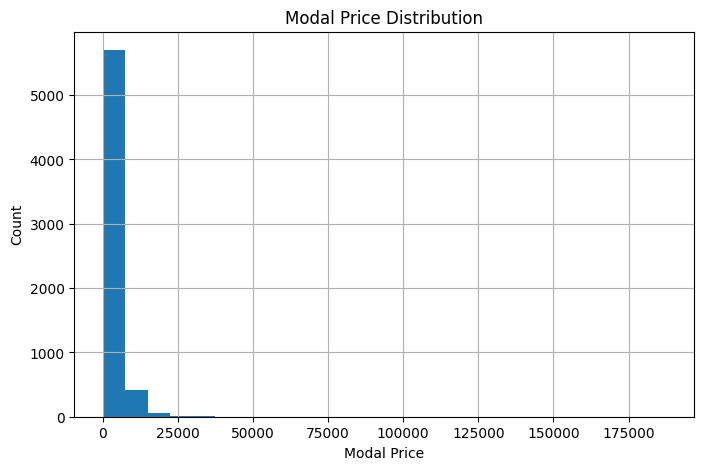

In [12]:
# Histogram: Modal Price
plt.figure(figsize=(8,5))
pdf["Modal_x0020_Price"].dropna().hist(bins=25)
plt.title("Modal Price Distribution")
plt.xlabel("Modal Price")
plt.ylabel("Count")
plt.show()

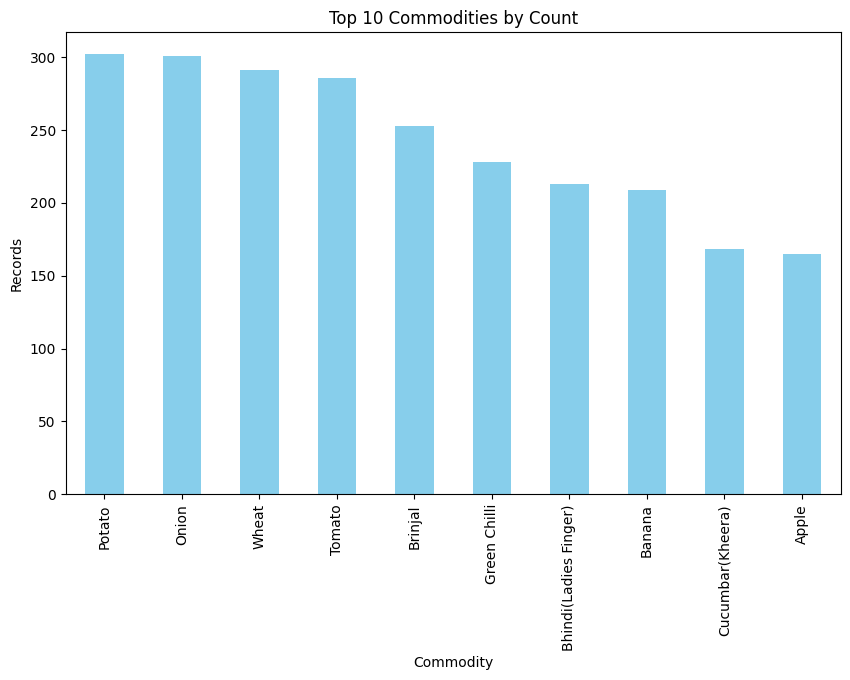

In [13]:
# Bar Chart: Top 10 Commodities
top_commodities = pdf["Commodity"].value_counts().head(10)
plt.figure(figsize=(10,6))
top_commodities.plot(kind="bar", color="skyblue")
plt.title("Top 10 Commodities by Count")
plt.xlabel("Commodity")
plt.ylabel("Records")
plt.show()

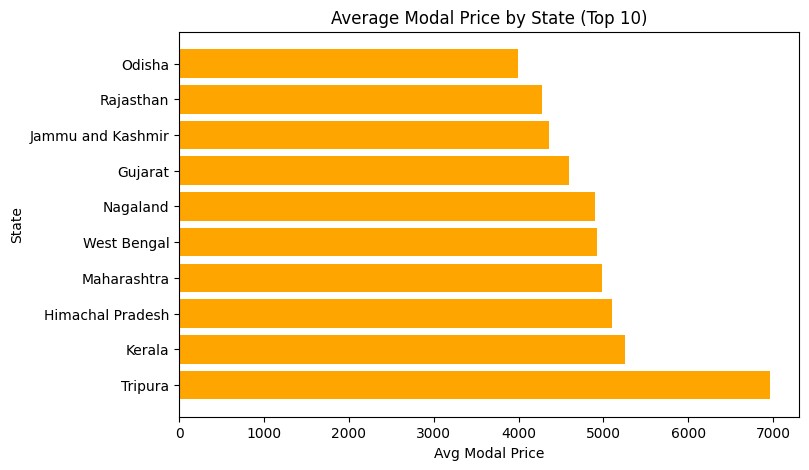

In [14]:
# Bar Chart: Average Modal Price by State (Top 10)
avg_modal_state_pd = avg_modal_state.toPandas().head(10)
plt.figure(figsize=(8,5))
plt.barh(avg_modal_state_pd["State"], avg_modal_state_pd["Avg_Modal_Price"], color="orange")
plt.title("Average Modal Price by State (Top 10)")
plt.xlabel("Avg Modal Price")
plt.ylabel("State")
plt.show()

<Figure size 1000x600 with 0 Axes>

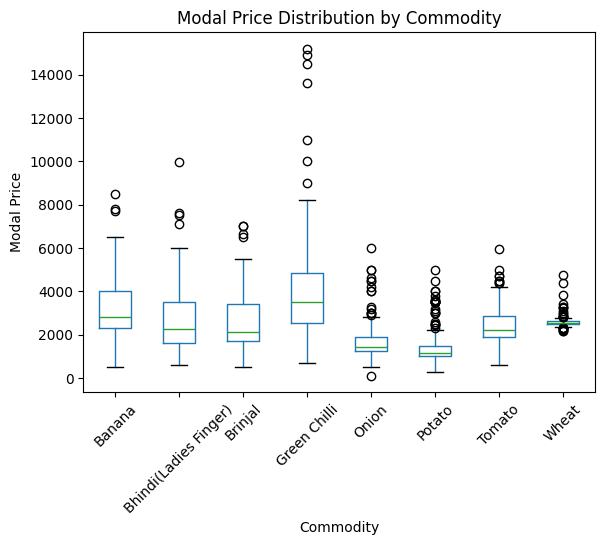

In [15]:
# Boxplot: Modal Price by Top Commodities
top_comms = pdf["Commodity"].value_counts().head(8).index.tolist()
subset = pdf[pdf["Commodity"].isin(top_comms)]
plt.figure(figsize=(10,6))
subset.boxplot(column="Modal_x0020_Price", by="Commodity", grid=False)
plt.title("Modal Price Distribution by Commodity")
plt.suptitle("")
plt.xlabel("Commodity")
plt.ylabel("Modal Price")
plt.xticks(rotation=45)
plt.show()


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel")

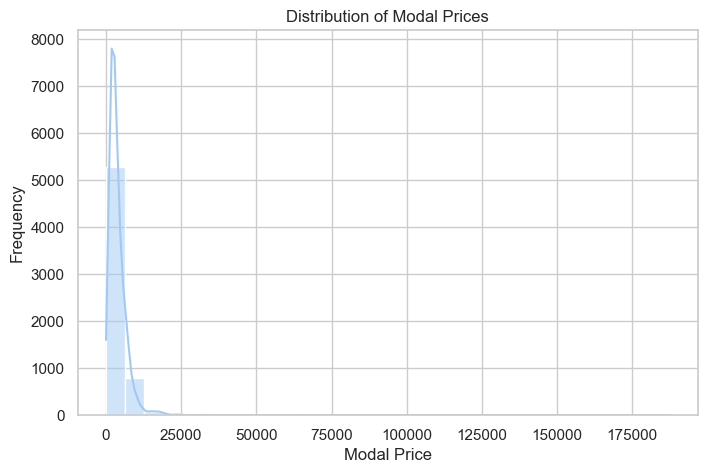

In [17]:
# Histogram: Modal Price
plt.figure(figsize=(8,5))
sns.histplot(pdf["Modal_x0020_Price"], bins=30, kde=True)
plt.title("Distribution of Modal Prices")
plt.xlabel("Modal Price")
plt.ylabel("Frequency")
plt.show()

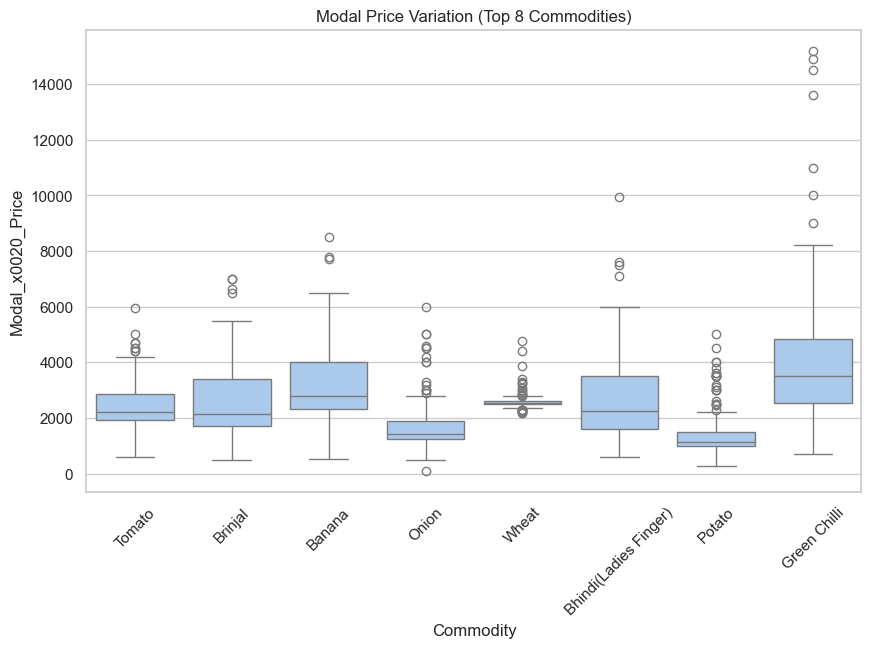

In [18]:
# Boxplot: Modal Price by Commodity (Top 8)
top_comms = pdf["Commodity"].value_counts().head(8).index.tolist()
subset = pdf[pdf["Commodity"].isin(top_comms)]
plt.figure(figsize=(10,6))
sns.boxplot(x="Commodity", y="Modal_x0020_Price", data=subset)
plt.title("Modal Price Variation (Top 8 Commodities)")
plt.xticks(rotation=45)
plt.show()

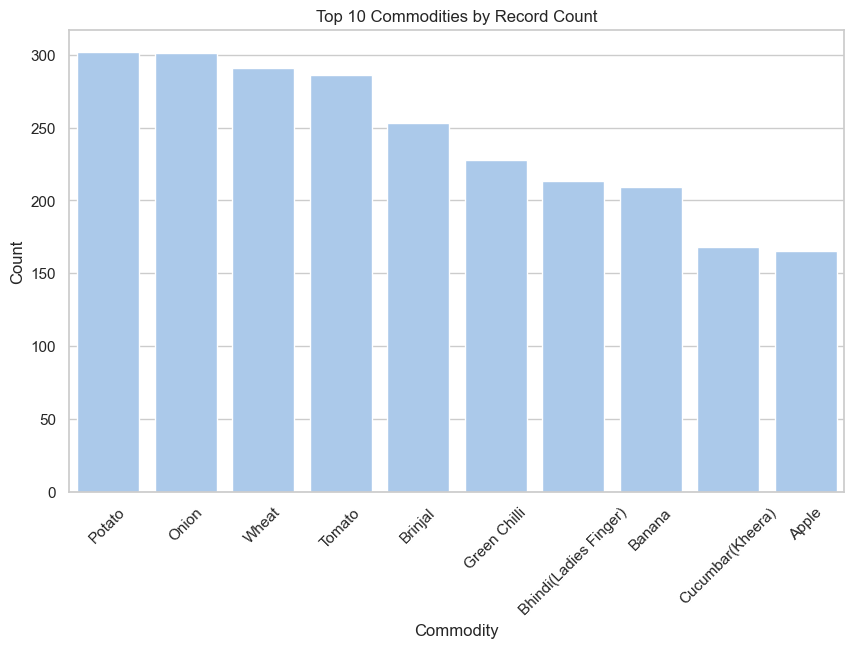

In [19]:
# Bar Chart: Top 10 Commodities by Record Count
plt.figure(figsize=(10,6))
top_counts = pdf["Commodity"].value_counts().head(10)
sns.barplot(x=top_counts.index, y=top_counts.values)
plt.title("Top 10 Commodities by Record Count")
plt.xlabel("Commodity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

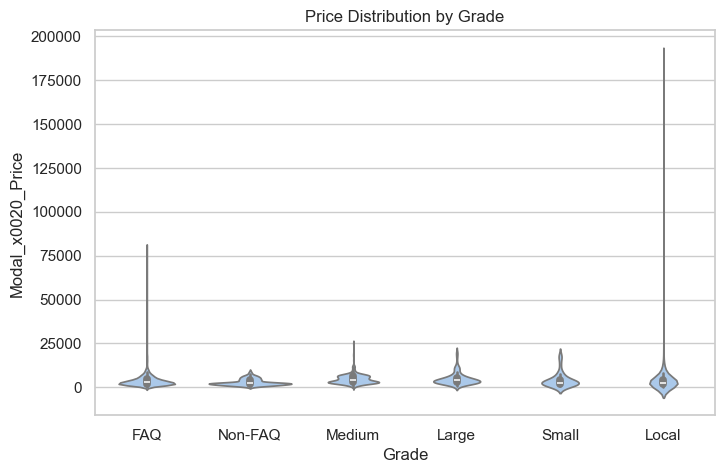

In [20]:
# Violin Plot: Modal Price by Grade
plt.figure(figsize=(8,5))
sns.violinplot(x="Grade", y="Modal_x0020_Price", data=pdf)
plt.title("Price Distribution by Grade")
plt.show()

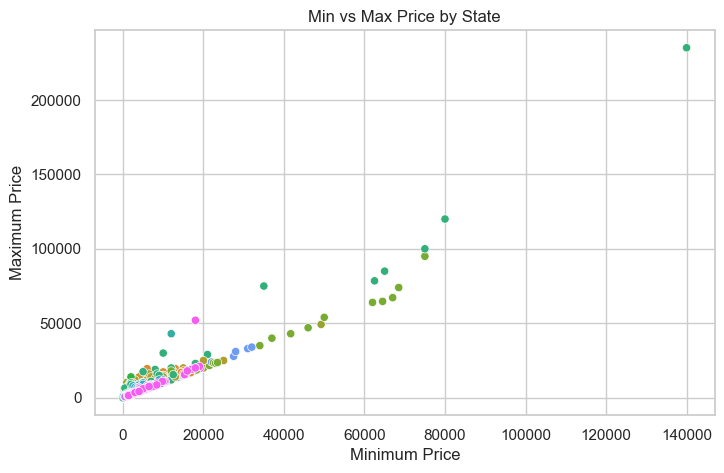

In [21]:
# Scatter Plot: Min vs Max Price
plt.figure(figsize=(8,5))
sns.scatterplot(x="Min_x0020_Price", y="Max_x0020_Price", hue="State", data=pdf, legend=False)
plt.title("Min vs Max Price by State")
plt.xlabel("Minimum Price")
plt.ylabel("Maximum Price")
plt.show()


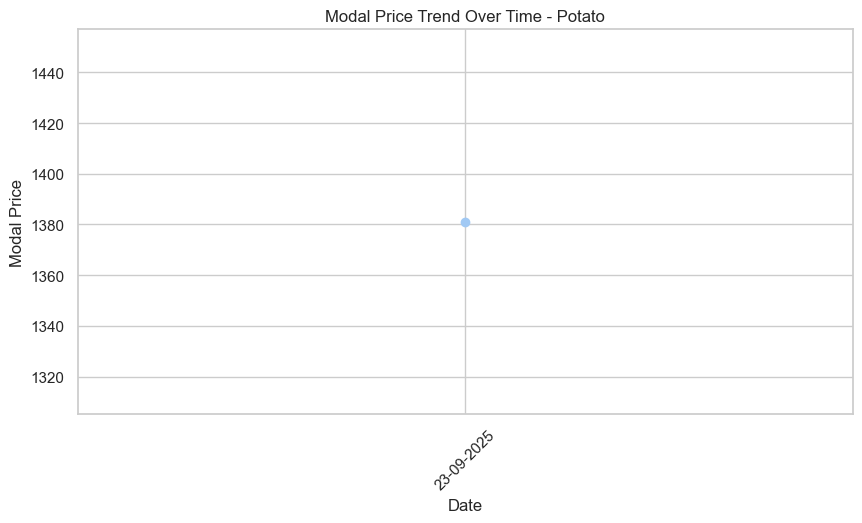

In [22]:
# Line Chart: Average Modal Price Trend (for one top Commodity)
main_item = top_comms[0]  # First top commodity
trend = pdf[pdf["Commodity"] == main_item].groupby("Arrival_Date")["Modal_x0020_Price"].mean().reset_index()
plt.figure(figsize=(10,5))
plt.plot(trend["Arrival_Date"], trend["Modal_x0020_Price"], marker="o")
plt.title(f"Modal Price Trend Over Time - {main_item}")
plt.xlabel("Date")
plt.ylabel("Modal Price")
plt.xticks(rotation=45)
plt.show()


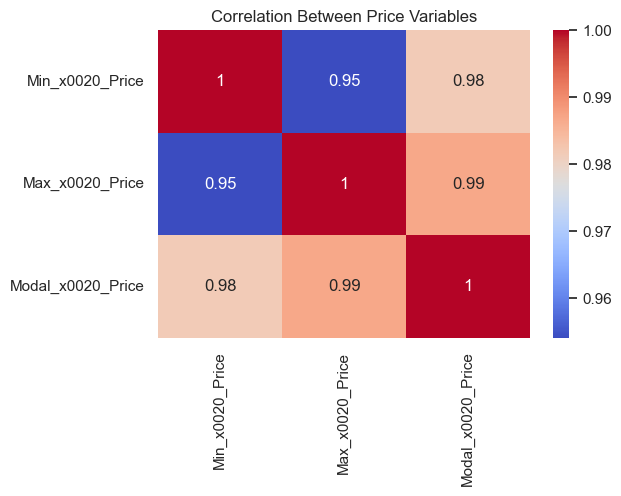

In [23]:
# Heatmap: Correlation Between Prices
plt.figure(figsize=(6,4))
sns.heatmap(pdf[["Min_x0020_Price", "Max_x0020_Price", "Modal_x0020_Price"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Price Variables")
plt.show()

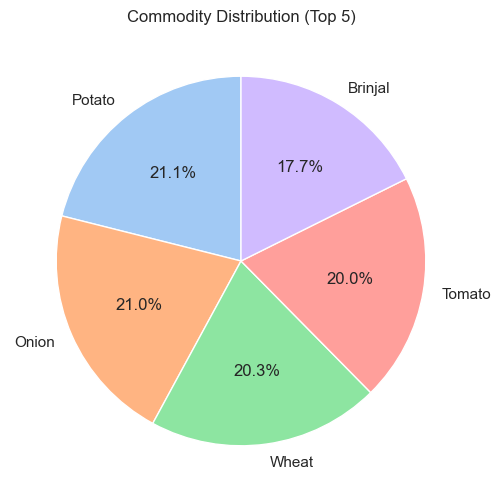

In [24]:
# Pie Chart: Commodity Distribution (Top 5)
top5 = pdf["Commodity"].value_counts().head(5)
plt.figure(figsize=(6,6))
plt.pie(top5.values, labels=top5.index, autopct='%1.1f%%', startangle=90)
plt.title("Commodity Distribution (Top 5)")
plt.show()

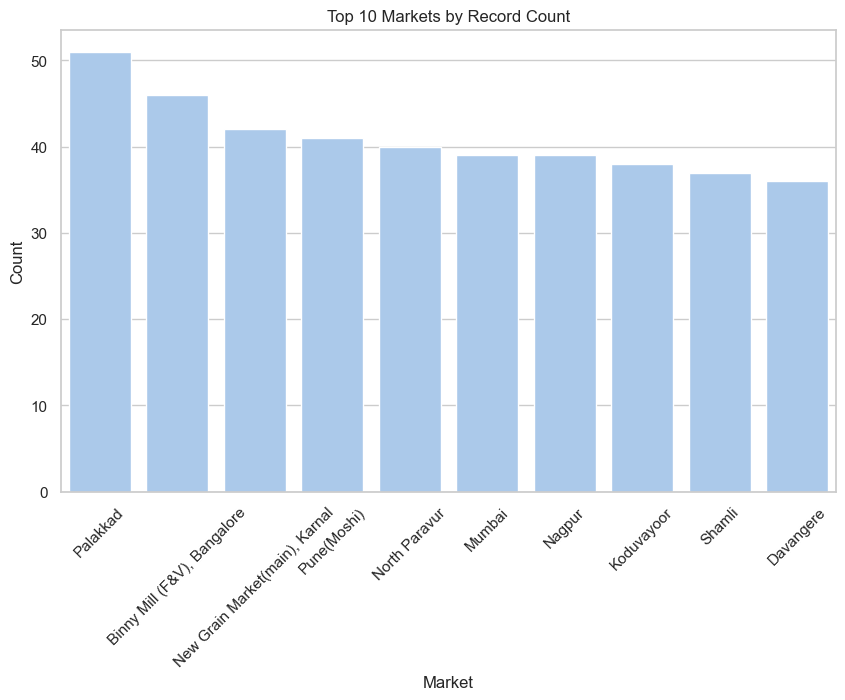

In [25]:
# Market Distribution (Top 10 Markets)
plt.figure(figsize=(10,6))
top_markets = pdf["Market"].value_counts().head(10)
sns.barplot(x=top_markets.index, y=top_markets.values)
plt.title("Top 10 Markets by Record Count")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

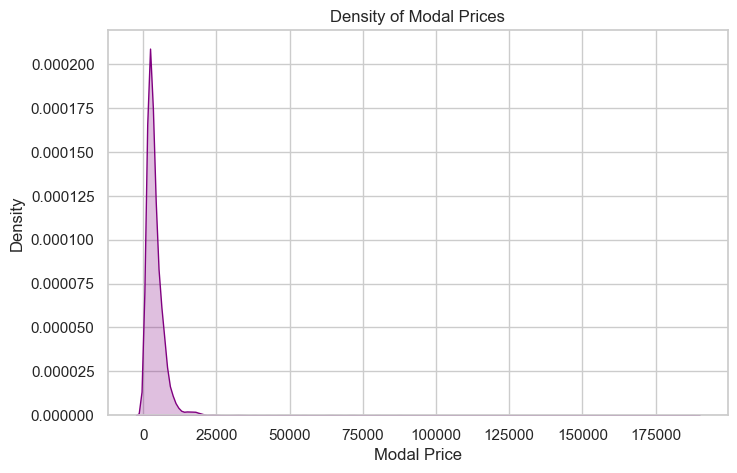

In [26]:
# KDE Plot: Density of Modal Prices
plt.figure(figsize=(8,5))
sns.kdeplot(pdf["Modal_x0020_Price"], fill=True, color="purple")
plt.title("Density of Modal Prices")
plt.xlabel("Modal Price")
plt.show()

In [27]:
# Stop Spark Session
spark.stop()

## Summary and Conclusion

The **Market Data Analysis using PySpark** project successfully explored and visualized agricultural price patterns across different states, commodities, and markets in India.

### **Key Findings**
- **Top Traded Commodities:** Potato, Onion, Tomato, Wheat, and Brinjal.  
- **High-Value Commodities:** Cardamom, Almond, and Black Pepper show exceptionally high modal prices.  
- **Regional Trends:** States like **Kerala, Tripura, and Himachal Pradesh** record higher average prices due to premium crops.  
- **Price Range:** ₹5 to ₹1,87,500 with an average modal price of ~₹3,942.  
- **Strong Correlation:** Min, Max, and Modal prices exhibit consistent relationships across markets.  
- **Market Diversity:** Balanced representation of multiple commodities and grades (FAQ, Standard).

### **Conclusion**
Using **PySpark**, the dataset was efficiently processed to reveal **price distribution trends, regional variations, and commodity-level insights**.  
This analysis demonstrates the potential of **data-driven decision-making in agriculture**, helping stakeholders understand market fluctuations and optimize trading strategies.

